In [1]:
import os,sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
from datetime import datetime, timedelta, time
import glob
from generate_atmosphere import LidarProfile,RadiosondeProfile
import miscLidar as mscLid
from molecular import rayleigh_scattering
import global_settings as gs
import pandas as pd
import preprocessing as prep
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline
from IPython.display import display

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIG_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIG_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIG_SIZE)     # fontsize of the figure title


C:\Users\addalin\Dropbox\Lidar\code\miscLidar.py:40: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  plt.rcParams['text.latex.preamble'] = [r"\usepackage{amsmath}"]


In [2]:
def daily_ds_histogram(dataset, profile_type='range_corr',
                       SAVE_FIG = False , dst_folder = os.path.join ( '..' , 'Figures' )
                       , format_fig = 'png' , dpi = 1000 ):
	import matplotlib.ticker as mticker
	from decimal import Decimal
	#logger = logging.getLogger ( )

	date_datetime = prep.get_daily_ds_date ( dataset )
	ds_profile = dataset.get(profile_type)
	df_stats = pd.DataFrame(columns=['wavelength [nm]', 'valid size', 'positive %', 'negative %'])
	fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6),sharey=True)
	ax = axes.ravel()
	th = 0
	colors = ['b','g','r']

	for ind,(wavelength,color) in enumerate(zip(wavelengths,colors)):
		sub_ds = ds_profile.sel(Wavelength = wavelength)
		orig_size = sub_ds.where(sub_ds != np.nan ).values.size

		# positive values histogram
		pos_vals = sub_ds.where(sub_ds > th).where(sub_ds != np.nan).values
		pos_vals = pos_vals[~np.isnan(pos_vals)]
		pos_size = pos_vals.size

		nbins = 100 #if pos_size>100 else 10
		hist, bins =np.histogram(pos_vals, bins=nbins)
		logbins = np.logspace(np.log10(bins[0]),np.log10(bins[-1]),len(bins))
		ax[1].hist(pos_vals, bins=logbins, label = f"$\lambda={wavelength}$",
		           alpha=0.4, color= color )
		ax[1].set_xscale('symlog')

		#negative values histogram

		neg_ds = sub_ds.where(sub_ds < -th).where(sub_ds != np.nan )#.values
		neg_vals= neg_ds.values[~np.isnan(neg_ds.values)]
		neg_size = neg_vals.size
		if neg_size>0:
			nbins = 100 if neg_size>100 else 1
			histneg, binsneg =np.histogram(neg_vals, bins=nbins)
			neg_logbins = np.logspace(np.log10(-binsneg[-1]),np.log10(-binsneg[0]),len(binsneg))
			ax[0].hist(-neg_vals, bins=neg_logbins, label = f"$\lambda={wavelength}$",
			           alpha=0.5 , color= color)

		df_stats.loc[ind] = [wavelength, orig_size, f"{100.0*pos_size/orig_size:.2f}" ,
		                   f"{100.0*neg_size/orig_size :.2f}"]

	# fixing xticks with FixedLocator but also using MaxNLocator to avoid cramped x-labels
	ticks_loc = ax[1].get_xticks().tolist()
	ax[1].xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
	new_posx_ticks = [f"$10^{np.log10(Decimal(n))}$" if n>0 else round(n) for n in ticks_loc]
	ax[1].set_xticklabels(new_posx_ticks)
	if neg_size>0:
		ax[0].set_xscale('log')
		ax[0].invert_xaxis()
		ax[0].set_xscale('symlog')
		#ax[0].legend()
		ticks_loc = ax[0].get_xticks()#.tolist()
		ax[0].xaxis.set_major_locator(mticker.FixedLocator(ticks_loc))
		new_negx_ticks = [f"$-10^{np.log10(Decimal(n))}$" if n>0 else round(n) for n in ticks_loc]
		ax[0].set_xticklabels(new_negx_ticks)

	ax[1].legend(loc= 'upper left')
	y_lim = ax[1].get_ylim()
	ax[0].set_ylim(y_lim)
	ax[0].ticklabel_format(axis='y', style='sci', scilimits=(0,0))
	ax[0].tick_params(axis='both', which='major', labelsize=14)
	ax[0].set_ylabel('counts', fontsize =18)
	ax[1].tick_params(axis='both', which='major', labelsize=14)
	xlabels = f"{ds_profile.long_name}\n[{ds_profile.units}]"
	ax[0].set_xlabel(xlabels,position=(1.05, 1e6), horizontalalignment='center', fontsize =18)
	print(date_datetime)
	stitle = f"Histogram of {ds_profile.info.lower()} " \
	         f"\n {dataset.attrs['location']} {date_datetime.strftime('%Y-%m-%d')}"
	fig.suptitle(stitle, fontsize = 24)
	plt.tight_layout()
	plt.show()

	if SAVE_FIG :
		fname = f"{date_datetime.strftime ( '%Y-%m-%d' )}_{dataset.attrs ['location']}_{profile_type}_" \
		        f"source_{dataset.attrs['source_type']}_histogram.{format_fig}"
		if not os.path.exists ( dst_folder ) :
			try :
			    os.makedirs ( dst_folder , exist_ok = True )
			    print (f"Creating folder: {dst_folder}") # logger.debug ( f"Creating folder: {dst_folder}" )
			except Exception :
				raise OSError ( f"Failed to create folder: {dst_folder}" )
		fpath = os.path.join ( dst_folder , fname )
		fig.savefig(fpath,bbox_inches='tight',dpi=dpi, format = format_fig)
		print(f"Figure saved at {fpath}") # logger.debug ( f"Figure saved at {fpath}" )
	return (fig,axes,df_stats)

def get_TROPOS_raw_nc_timestamp(nc_path):
	format_filename = r"(.*)_(.*)_TROPOS_(.*)_01.nc"
	format_times = ["%Y_%m_%d","%a", "%H_%M"]
	date_time = prep.extract_date_time(nc_path,format_filename, format_times)
	timestamp = datetime.combine(date = date_time[0].date(),time=date_time[2].time())
	return timestamp


# Exploring dynamic range of the signal
#### This notebook compares the range corrected signal retrieved from two sources:
#### 1. The raw lidar measurements as : $(p-p_{bg})\cdot r^2 $
#### 2. The post analysed signal by TROPOS as: $att\_bsc \cdot CL $
> Where:
> 1. $att\_bsc = \beta \cdot \exp(-2\tau)$
> $(p - p_{bg})\cdot r^2 \cdot  = att\_bsc\cdot CL$
> 2. The values $att\_bsc$ and $CL$ are found in the files: `*att_bsc.nc`
> 3. The lidar measurements are found in the files: `measure_datetime.strftime(%Y_%m_%d_%a_TROPOS_%H_%m_01.nc)`,
> where `measure_datetime` is the start measure time of the file, e.g., 2017_09_12_Tue_TROPOS_18_00_01.nc`


In [3]:
print('load station and setting date')

'''set day'''
day_date = datetime(2017,9,13)
print(day_date)

'''set station'''

station = gs.Station('Haifa')
print(station)

load station and setting date
2017-09-13 00:00:00

 <class 'global_settings.Station'>:
  {'name': 'Haifa',
   'location': 'Haifa',
   'lon': 35.02,
   'lat': 32.8,
   'altitude': 230.0,
   'start_bin_height': 78.75,
   'end_bin_height': 22485.66016,
   'n_bins': 3000,
   'dt': 5.0000000000000004e-08,
   'gdas1_folder': 'H:\\data_haifa\\DATA FROM TROPOS\\GDAS\\haifa',
   'gdastxt_folder': 'H:\\data_haifa\\DATA FROM TROPOS\\GDAS\\haifa_preproc',
   'lidar_src_folder': 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS',
   'molecular_dataset': 'D:\\data_haifa\\DATA FROM TROPOS\\molecular_dataset',
   'lidar_dataset': 'D:\\data_haifa\\DATA FROM TROPOS\\lidar_dataset',
   'db_file': 'H:\\data_haifa\\DATA FROM TROPOS\\data\\level1a\\PollyXT_TROPOS\\pollyxt_tropos_calibration.db',
   'aeronet_folder': 'D:\\data_haifa\\AERONET',
   'aeronet_name': 'Technion_Haifa_IL'}


In [4]:
LOAD_LIDAR_DS = True
if LOAD_LIDAR_DS:
	lidar_ncpaths= prep.get_prep_dataset_paths ( station , day_date ,
	                                             data_source = 'lidar',
	                                             file_type = 'range_corr')

	print(lidar_ncpaths)

['D:\\data_haifa\\DATA FROM TROPOS\\lidar_dataset\\2017\\09\\2017_09_13_Haifa_range_corr_1064_lidar.nc', 'D:\\data_haifa\\DATA FROM TROPOS\\lidar_dataset\\2017\\09\\2017_09_13_Haifa_range_corr_355_lidar.nc', 'D:\\data_haifa\\DATA FROM TROPOS\\lidar_dataset\\2017\\09\\2017_09_13_Haifa_range_corr_532_lidar.nc', 'D:\\data_haifa\\DATA FROM TROPOS\\lidar_dataset\\2017\\09\\2017_09_13_Haifa_range_corr_lidar.nc']


In [5]:
if LOAD_LIDAR_DS:
	print( 'Load range corr in all channels')
	netcdf = lidar_ncpaths[-1]
	ds_range_corr_daily =  prep.load_dataset(netcdf)
	display(ds_range_corr_daily)

Load range corr in all channels


<xarray.Dataset>
Dimensions:         (Height: 3000, Time: 2880, Wavelength: 3)
Coordinates:
  * Time            (Time) datetime64[ns] 2017-09-13 ... 2017-09-13T23:59:30
  * Height          (Height) float64 0.3088 0.3162 0.3237 ... 22.7 22.71 22.72
  * Wavelength      (Wavelength) uint64 355 532 1064
Data variables:
    range_corr      (Wavelength, Height, Time) float32 1.028e+05 ... -2.189e+06
    lambda_nm       (Wavelength) uint32 355 532 1064
    plot_min_range  (Wavelength) float64 0.0 0.0 0.0
    plot_max_range  (Wavelength) float64 9.582e+07 1.276e+08 7.618e+07
    date            datetime64[ns] 2017-09-13
Attributes:
    location:     Haifa
    info:         Daily range corrected lidar signal
    source_type:  att_bsc

In [6]:
if LOAD_LIDAR_DS:
	print( 'Load range corr per channel')
	netcdf = lidar_ncpaths[0]
	ds_load_pr2_chan = prep.load_dataset(netcdf)
	display(ds_load_pr2_chan)

Load range corr per channel


<xarray.Dataset>
Dimensions:         (Height: 3000, Time: 2880)
Coordinates:
  * Time            (Time) datetime64[ns] 2017-09-13 ... 2017-09-13T23:59:30
  * Height          (Height) float64 0.3088 0.3162 0.3237 ... 22.7 22.71 22.72
    Wavelength      uint64 ...
Data variables:
    range_corr      (Height, Time) float64 0.0 1.24e+04 ... 0.0 -2.189e+06
    lambda_nm       uint32 1064
    plot_min_range  float64 0.0
    plot_max_range  float64 7.618e+07
    date            datetime64[ns] 2017-09-13
Attributes:
    location:     Haifa
    info:         Daily range corrected lidar signal
    source_type:  att_bsc

In [7]:
#format_fig = 'png'
#dpi_ = 1000
SAVE_FIG = False
VIS_LIDAR_DS = True

visualizing without range_plot:


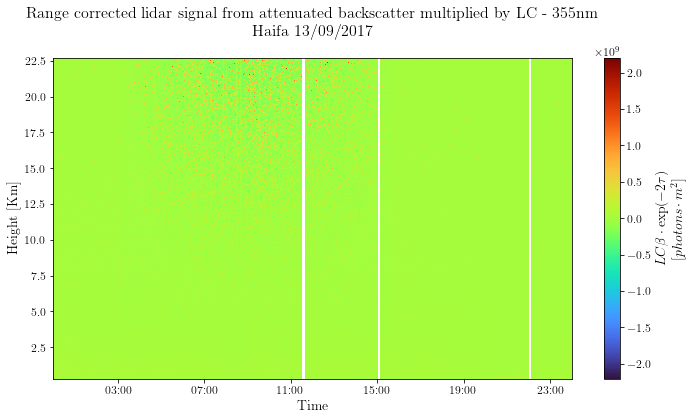

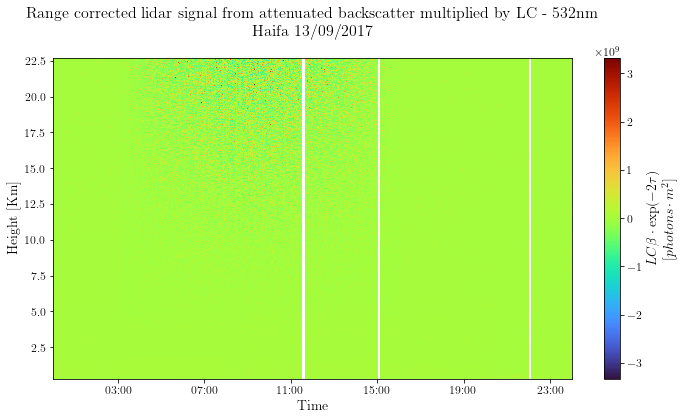

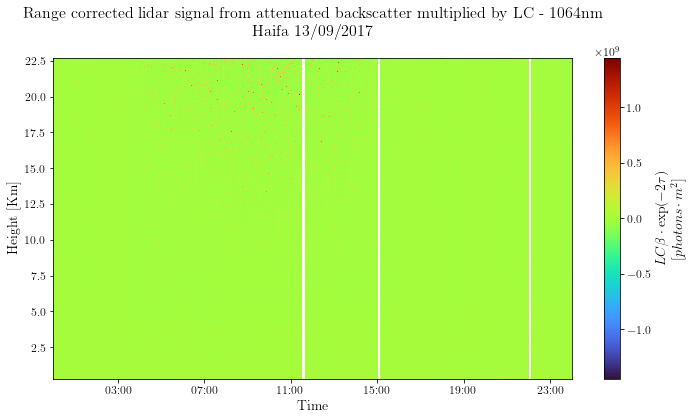

In [8]:
if VIS_LIDAR_DS:
	wavelengths = ds_range_corr_daily.Wavelength.values.tolist()
	print('visualizing without range_plot:')
	for wav in wavelengths:
		profile_type = 'range_corr'
		USE_RANGE = None
		g = prep.visualize_ds_profile_chan(ds_range_corr_daily, wav,
		                                   profile_type = profile_type, SAVE_FIG= SAVE_FIG)

Visualizing within the 'range_plot' bounding values:


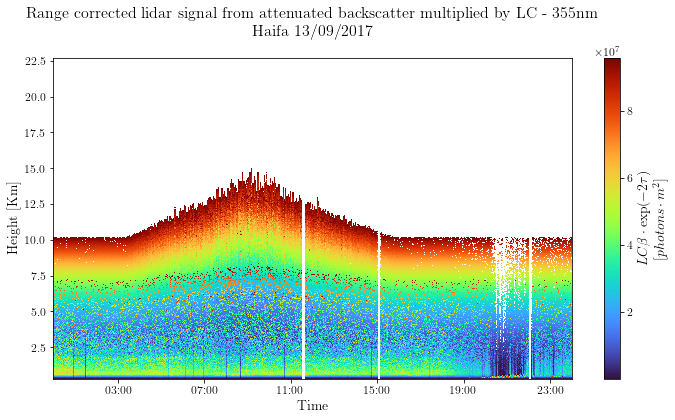

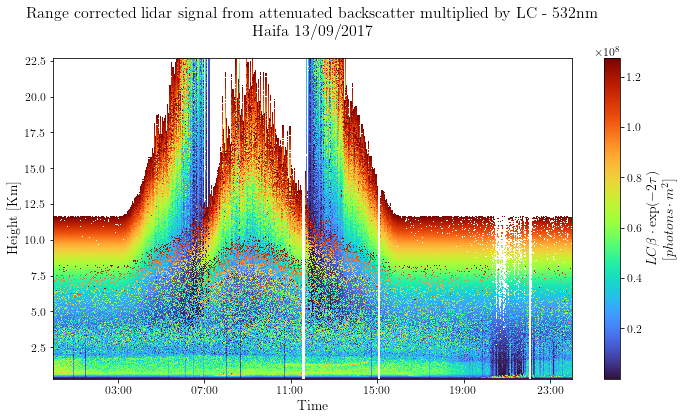

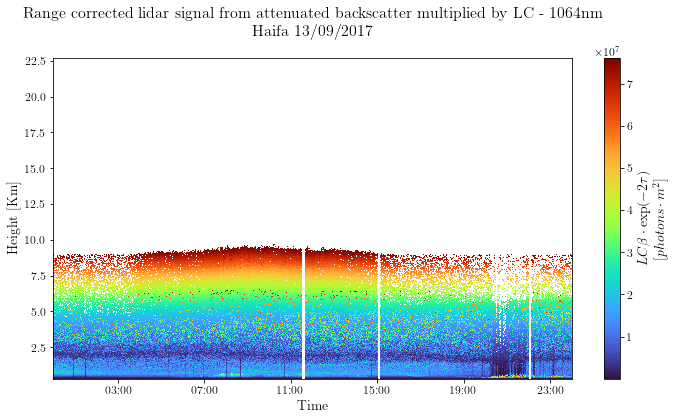

In [9]:
if VIS_LIDAR_DS:
	print("Visualizing within the 'range_plot' bounding values:")
	for wav in wavelengths:
		g = prep.visualize_ds_profile_chan(ds_range_corr_daily, wav,
		                                   profile_type = profile_type,USE_RANGE='MID', SAVE_FIG= SAVE_FIG)

Visualizing below the 'range_plot':


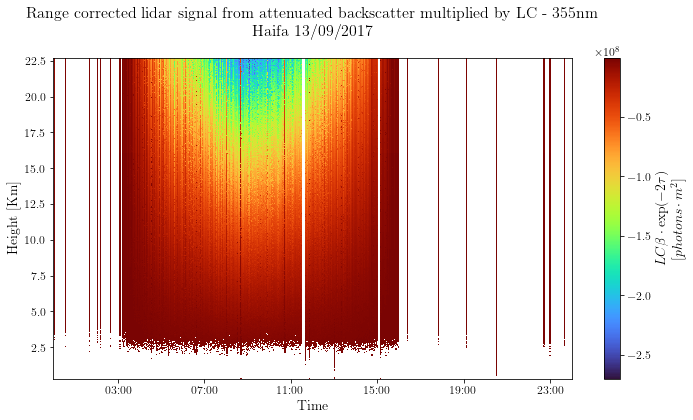

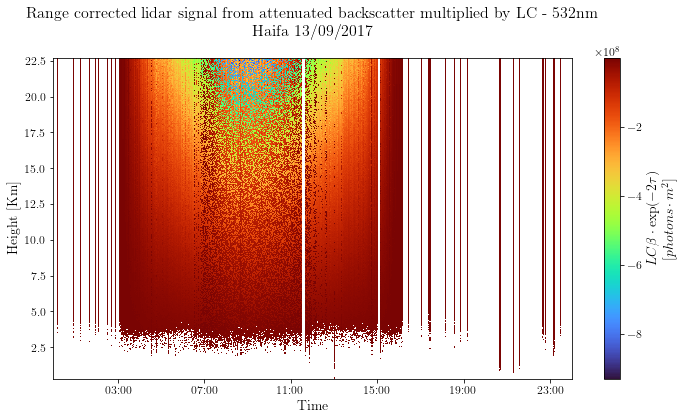

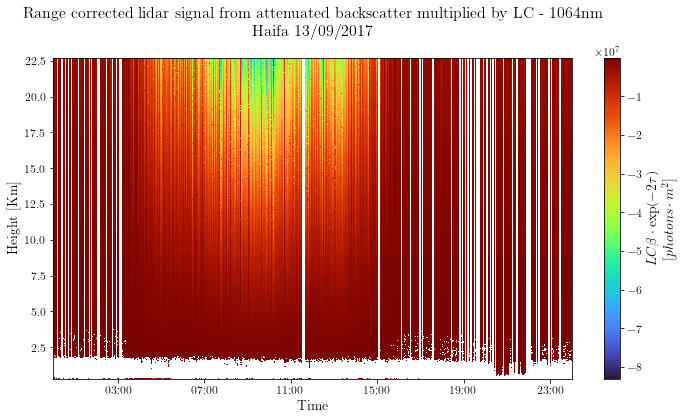

In [10]:
if VIS_LIDAR_DS:
	print("Visualizing below the 'range_plot':")
	for wav in wavelengths:
		g = prep.visualize_ds_profile_chan(ds_range_corr_daily, wav,
                                   profile_type = profile_type,USE_RANGE='LOW', SAVE_FIG= SAVE_FIG)

Visualizing above the 'range_plot':


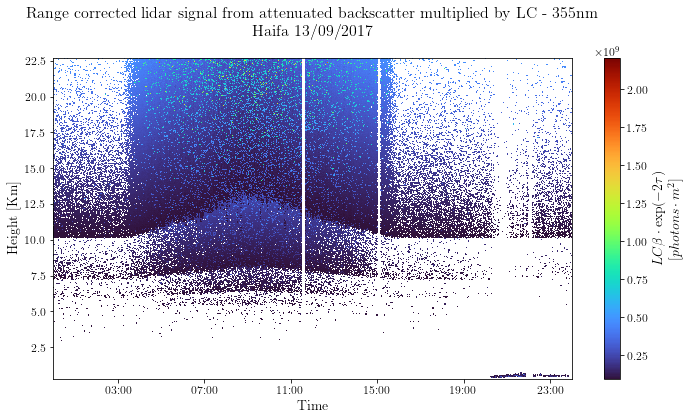

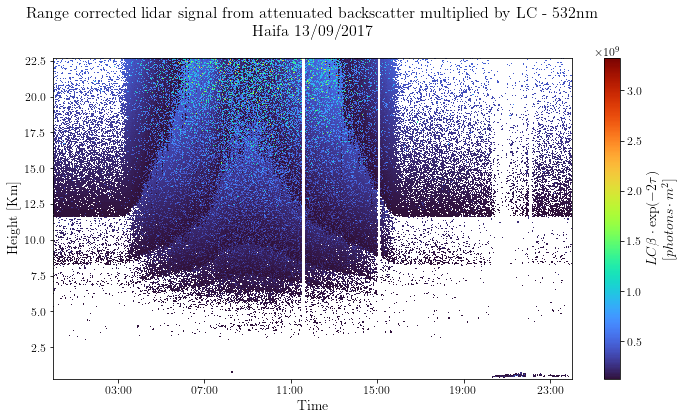

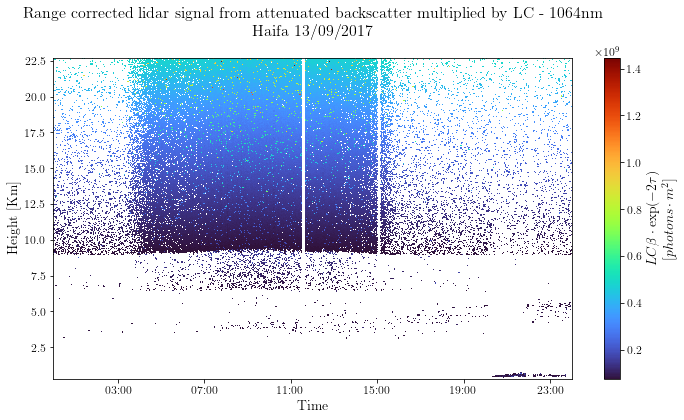

In [11]:
if VIS_LIDAR_DS:
	print("Visualizing above the 'range_plot':")
	for wav in wavelengths:
		g = prep.visualize_ds_profile_chan(ds_range_corr_daily, wav,
                                   profile_type = profile_type,USE_RANGE='HIGH', SAVE_FIG= SAVE_FIG)

2017-09-13 00:00:00


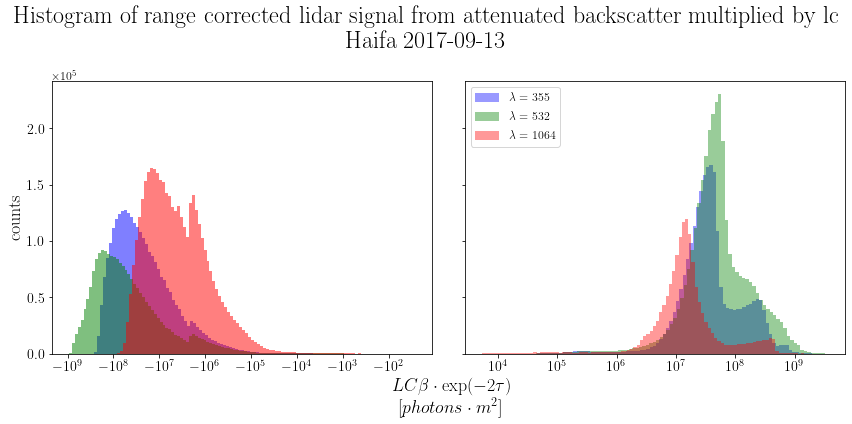

,wavelength [nm],valid size,positive %,negative %
0,355,8640000,27.70,31.61
1,532,8640000,37.43,24.80
2,1064,8640000,16.92,46.79


In [12]:
if VIS_LIDAR_DS:
	_,_,df_stats= daily_ds_histogram(ds_range_corr_daily)#, profile='range_corr', SAVE_FIG = True)
	display(df_stats)


In [13]:
netcdf_folder = r"C:\Users\addalin\Dropbox\Lidar\code\data examples\lidar netcdf"
raw_nc_paths = sorted(glob.glob(os.path.join(netcdf_folder,"*.nc")))
timestamps = [get_TROPOS_raw_nc_timestamp(path) for path in raw_nc_paths]
print(timestamps)
df_times = pd.DataFrame(data = timestamps, columns = ['timestamp'])

days_g = df_times.groupby([df_times.timestamp.dt.date]).groups
days = list(days_g.keys())
#print(days)

for day in days[1:2]:
	dt_day = datetime.combine(date = day, time =  time.min)
	dstamps = [timestamps[ind] for ind in days_g[day].tolist()]
	print(f'day: {day}, hours:{dstamps}')
	ds_hours = []
	for stamp in dstamps:
		filename = f"{stamp.strftime('%Y_%m_%d')}_{stamp.strftime('%a')}_TROPOS_{stamp.strftime('%H_%M')}_01.nc"
		lidar_ds = prep.load_dataset(os.path.join(netcdf_folder,filename))
		print(filename)
		#print()
		#display(lidar_ds)

		channels =  gs.CHANNELS().get_elastic()
		wavelengths = gs.LAMBDA_nm().get_elastic()
		ds_chans = []

		# Separate bins to:
		# 1. background bins (pre-triggered)
		# 2. height bins of the raw signal (post-triggered)
		total_bins = lidar_ds.height.shape[0]
		pt_bin = 248 # pre-triggered bins
		height_bins = lidar_ds.height.values[pt_bin:total_bins]
		bg_bins = lidar_ds.height.values[0:pt_bin]
		n_heights =  height_bins.shape[0] # This value is useful for estimation of background signal from poisson distribution.

		# Calculate range and range^2
		height_res = lidar_ds.measurement_height_resolution.values * 1e-9
		range = np.array([(h_ind+1) * (gs.C_m_s*height_res)/2 for h_ind in (height_bins-pt_bin)])
		r2 = range**2  # this value is used to calculate range corrected signal: pr^2


		# Set height indexes
		altitude = lidar_ds.location_height.values
		range_km  = (range + altitude)* 1e-3

		# Set time indexes
		end_time = stamp + timedelta(hours=6) - timedelta(seconds = 30)
		times = pd.date_range(start =stamp,end = end_time, freq = '30S')

		# get raw signal per channel
		for chan,lambda_nm in zip(channels, wavelengths):
			df_bg = lidar_ds.sel(channel = chan , height = bg_bins).raw_signal.transpose(transpose_coords = True).to_pandas()
			df_raw = lidar_ds.sel(channel = chan, height = height_bins).raw_signal.transpose(transpose_coords = True).to_pandas()

			# calculate background signal
			df_mean_bg = df_bg.mean(axis=0)
			# bg_df = pd.DataFrame(np.array([mscLid.generate_poisson_signal(mu= mu_k,n= n_heights) for mu_k in mean_bg]).astype(np.int).T)

			# remove bg signal
			df_signal = df_raw - df_mean_bg
			#df_signal[df_signal<0]=0

			#calc range corrected signal
			df_pr2 = df_signal.apply(lambda row,r2: row*r2, axis=0,args = (r2,), result_type ='expand')
			#display(df_pr2)


			ds_chan= xr.Dataset (
			        data_vars = {'range_corr' : (('Height' , 'Time') , df_pr2    ),
			                     'bg_mean'    : (('Time')            , df_mean_bg),
			                     'raw_signal' : (('Height' , 'Time') , df_raw    ),
			                     'lambda_nm'  : ('Wavelength'        , [ lambda_nm ]   )
			                     } ,
			        coords = {'Height' : range_km ,
			                  'Time' : times.values,
							  'Wavelength' : [ lambda_nm ]})
			ds_chan.range_corr.attrs = {'long_name' : r'$p r^2$' ,
			                                       'units' : r'$photons \cdot m^2$' ,
			                                       'info' : 'Range corrected from raw lidar signal'}
			ds_chan.bg_mean.attrs = {'long_name' : r'$<p_{bg}>$' ,
			                                       'units' : r'$photons$' ,
			                                       'info' : 'Mean background from raw lidar signal'}
			ds_chan.raw_signal.attrs = {'long_name' : r'$p$' ,
			                                       'units' : r'$photons$' ,
			                                       'info' : 'Raw lidar signal'}
			# set attributes of coordinates
			ds_chan.Height.attrs = {'units' : '{}'.format ( '{}'.format ( 'km' ) ) ,
			                     'info' : 'Measurements heights above ground level'}
			ds_chan.Wavelength.attrs = {'long_name' : r'$\lambda$' , 'units' : r'$nm$'}

			ds_chans.append(ds_chan)

		cur_ds = xr.concat ( ds_chans , dim = 'Wavelength' )
		ds_hours.append(cur_ds)

ds_lidar_daily = xr.merge ( ds_hours , compat = 'no_conflicts' )
#display(ds_lidar_daily)

# Fixing missing timestamps values:
time_indx = pd.date_range(start = dt_day, end = (dt_day+timedelta(hours = 24)-timedelta(seconds = 30)), freq = '30S')
ds_lidar_daily = ds_lidar_daily.reindex ( {"Time" : time_indx} , fill_value = 0 )
# Adding info attributes:
ds_lidar_daily [ 'date' ] = dt_day
ds_lidar_daily.attrs [ 'location' ] = station.location
ds_lidar_daily.attrs [ 'info' ] = 'Daily measured lidar signals'
ds_lidar_daily.attrs ['source_type'] = 'raw'
display(ds_lidar_daily)

[datetime.datetime(2017, 9, 12, 18, 0), datetime.datetime(2017, 9, 13, 0, 0), datetime.datetime(2017, 9, 13, 6, 0), datetime.datetime(2017, 9, 13, 18, 0), datetime.datetime(2017, 9, 14, 0, 0), datetime.datetime(2017, 9, 14, 6, 0), datetime.datetime(2018, 9, 12, 18, 0), datetime.datetime(2018, 9, 13, 0, 0), datetime.datetime(2018, 9, 13, 18, 0)]
day: 2017-09-13, hours:[datetime.datetime(2017, 9, 13, 0, 0), datetime.datetime(2017, 9, 13, 6, 0), datetime.datetime(2017, 9, 13, 18, 0)]
2017_09_13_Wed_TROPOS_00_00_01.nc
2017_09_13_Wed_TROPOS_06_00_01.nc
2017_09_13_Wed_TROPOS_18_00_01.nc


<xarray.Dataset>
Dimensions:     (Height: 6152, Time: 2880, Wavelength: 3)
Coordinates:
  * Time        (Time) datetime64[ns] 2017-09-13 ... 2017-09-13T23:59:30
  * Height      (Height) float64 0.2375 0.245 0.2525 0.26 ... 46.32 46.33 46.34
  * Wavelength  (Wavelength) int64 355 532 1064
Data variables:
    range_corr  (Wavelength, Height, Time) float64 0.0 0.0 ... 0.0 -8.572e+06
    bg_mean     (Wavelength, Time) float64 0.0 0.0 0.0 ... 0.008065 0.0 0.004032
    raw_signal  (Wavelength, Height, Time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    lambda_nm   (Wavelength) int32 355 532 1064
    date        datetime64[ns] 2017-09-13
Attributes:
    location:     Haifa
    info:         Daily measured lidar signals
    source_type:  raw

In [14]:
top_h =ds_lidar_daily.Height[3000].values.tolist()
min_h = ds_lidar_daily.Height[0].values.tolist()
top_h

22.72192916145

In [15]:
ds_lidar_daily.Height.values[0]

0.23749481144999998

In [16]:
topCL_h_gnd = 15.0 + altitude * 1e-3 # km
micCL_h_gnd = 0.0 + altitude * 1e-3
topCL_h = ds_lidar_daily.Height[np.abs(ds_lidar_daily.Height.values - topCL_h_gnd).argmin()].values
minCL_h = ds_lidar_daily.Height[np.abs(ds_lidar_daily.Height.values - micCL_h_gnd).argmin()].values
print(f'calibration range: [{minCL_h:.2f},{topCL_h:.2f}] [km] - above sea level')

calibration range: [0.24,15.23] [km] - above sea level


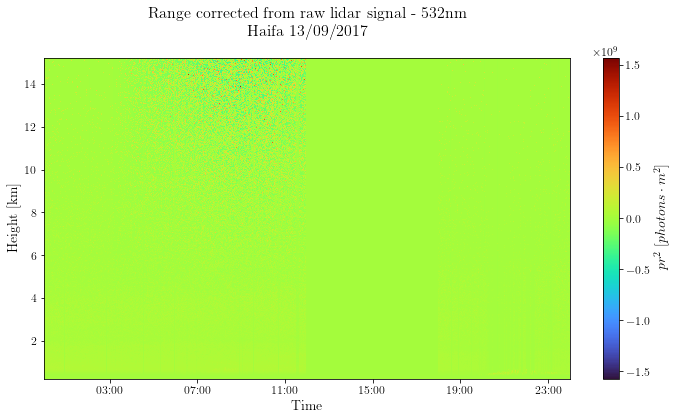

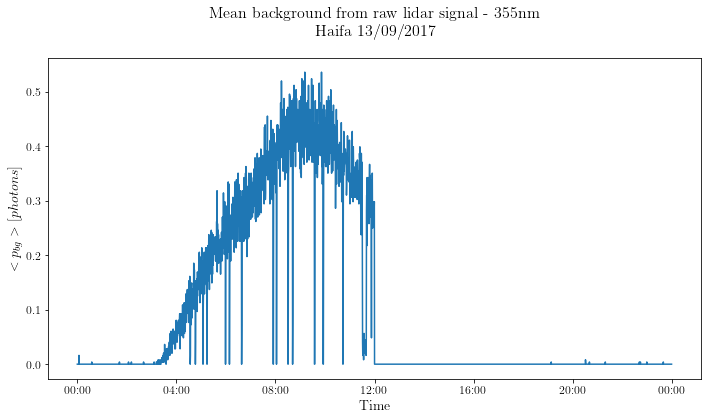

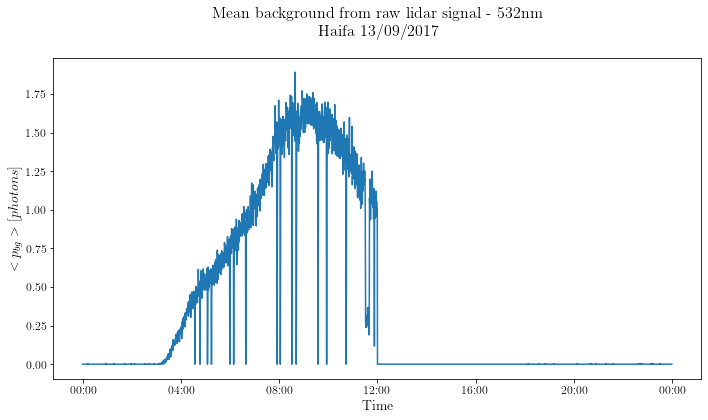

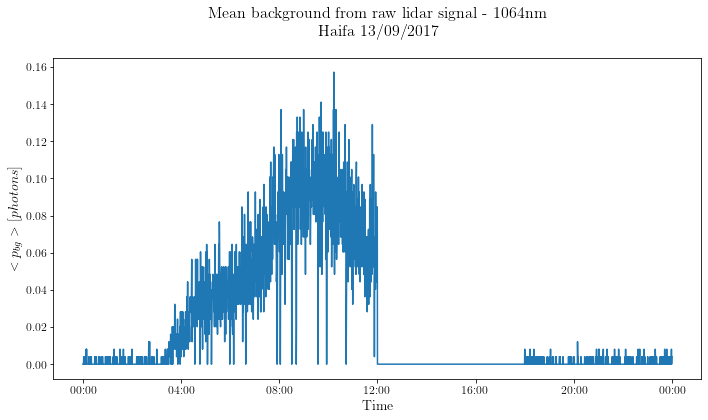

In [17]:
SAVE_FIG = False
lambda_nm=532
g1 = prep.visualize_ds_profile_chan(ds_lidar_daily.sel( Height = slice(minCL_h,topCL_h)), lambda_nm,
		                                   profile_type = 'range_corr', SAVE_FIG= SAVE_FIG)
for lambda_nm in wavelengths:
	g2 = prep.visualize_ds_profile_chan(ds_lidar_daily, lambda_nm = lambda_nm,
	                                    profile_type = 'bg_mean', SAVE_FIG= SAVE_FIG)

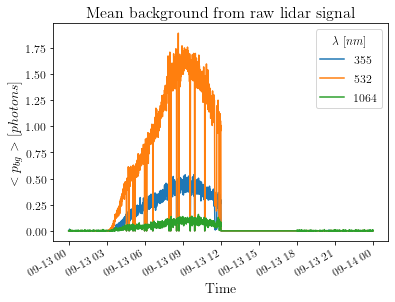

In [18]:
ds_lidar_daily.bg_mean.plot(hue = 'Wavelength')
plt.title(ds_lidar_daily.bg_mean.attrs['info'])
plt.show()

In [19]:
maxbg_g = ds_lidar_daily.bg_mean.sel(Wavelength=532).max().item()
maxbg_ir = ds_lidar_daily.bg_mean.sel(Wavelength=1064).max().item()
maxbg_b = ds_lidar_daily.bg_mean.sel(Wavelength=355).max().item()
(maxbg_g,maxbg_ir,maxbg_b)
(maxbg_g,maxbg_g/maxbg_ir,maxbg_g/maxbg_b)

(1.8911290322580645, 12.025641025641026, 3.5263157894736845)

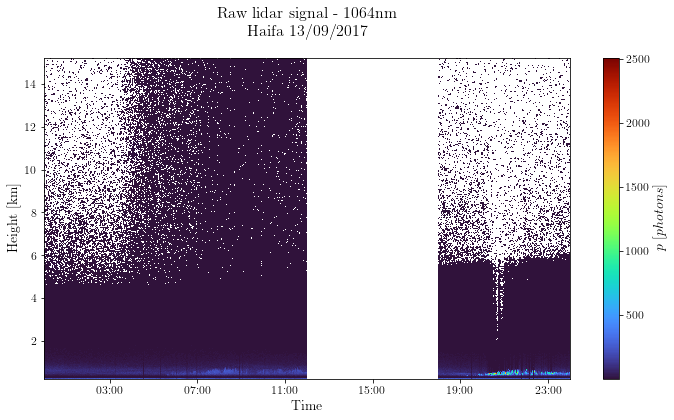

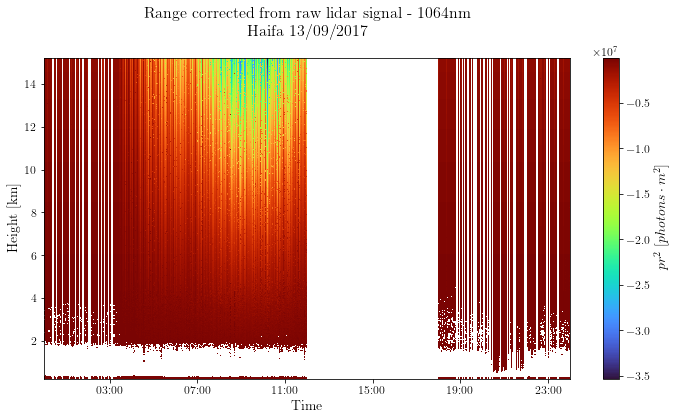

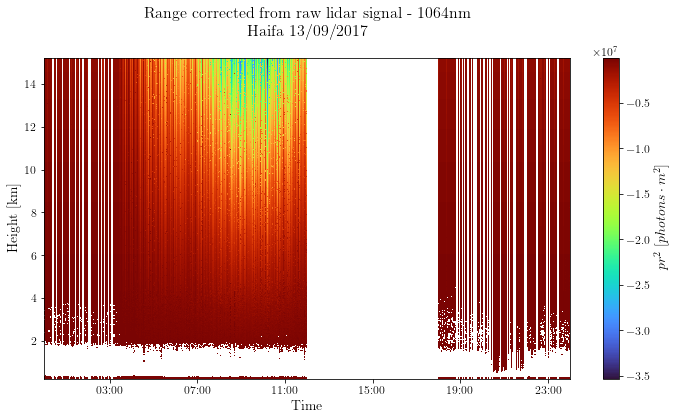

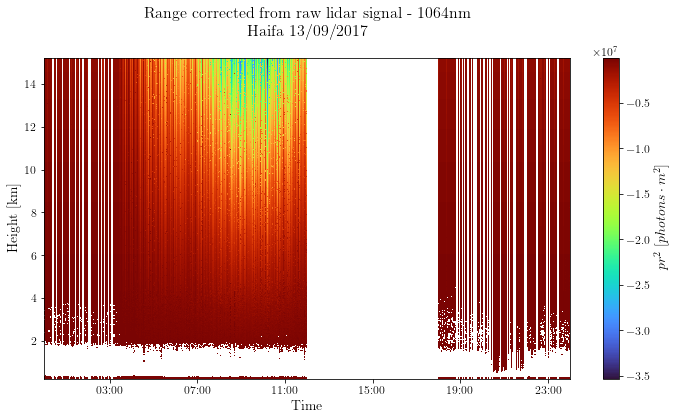

In [20]:
g3 = prep.visualize_ds_profile_chan(ds_lidar_daily.sel( Height = slice(minCL_h,topCL_h)),
                               lambda_nm = lambda_nm,profile_type = 'raw_signal',SAVE_FIG= SAVE_FIG)

for wav in wavelengths:
	g = prep.visualize_ds_profile_chan(ds_lidar_daily.sel( Height = slice(minCL_h,topCL_h)), lambda_nm,
		                                   profile_type = 'range_corr', SAVE_FIG= SAVE_FIG, USE_RANGE='LOW')

2017-09-13 00:00:00
2017-09-13 00:00:00


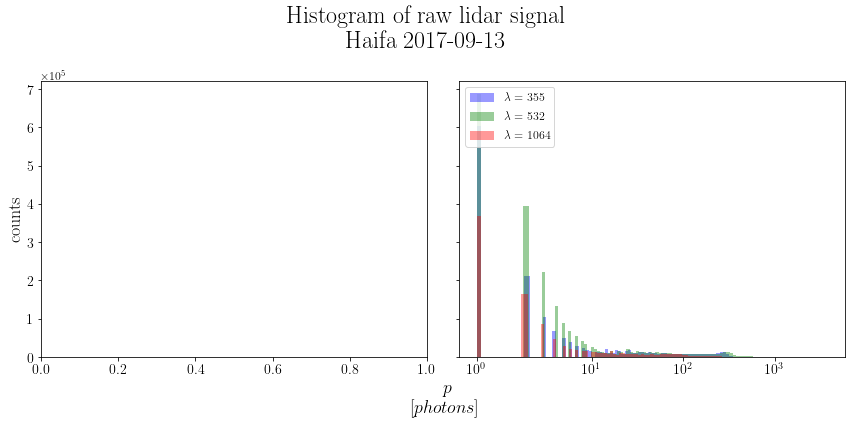

,wavelength [nm],valid size,positive %,negative %
0,355,5762880,27.59,0.00
1,532,5762880,38.53,0.00
2,1064,5762880,18.05,0.00


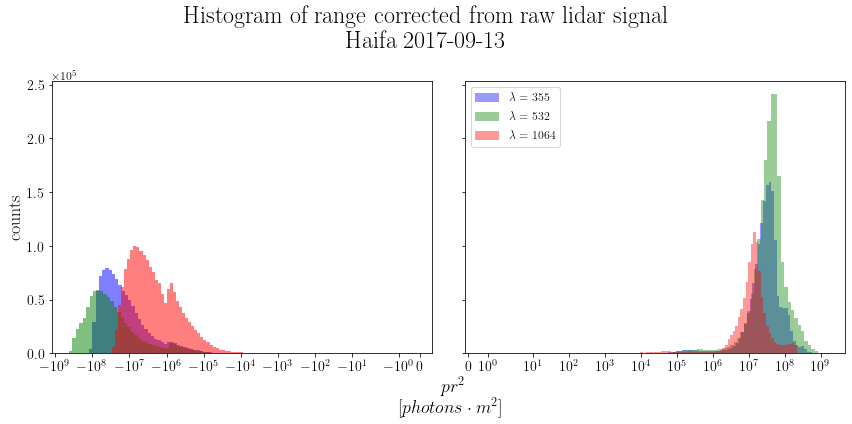

,wavelength [nm],valid size,positive %,negative %
0,355,5762880,27.59,18.85
1,532,5762880,33.80,15.02
2,1064,5762880,18.05,30.93


In [21]:
_,_,df_stats = daily_ds_histogram(ds_lidar_daily.sel( Height = slice(minCL_h,topCL_h)),
                                  profile_type='raw_signal', SAVE_FIG = SAVE_FIG)
display(df_stats)

_,_,df_stats = daily_ds_histogram(ds_lidar_daily.sel( Height = slice(minCL_h,topCL_h)),
                                  profile_type='range_corr', SAVE_FIG = SAVE_FIG)
display(df_stats)
